In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

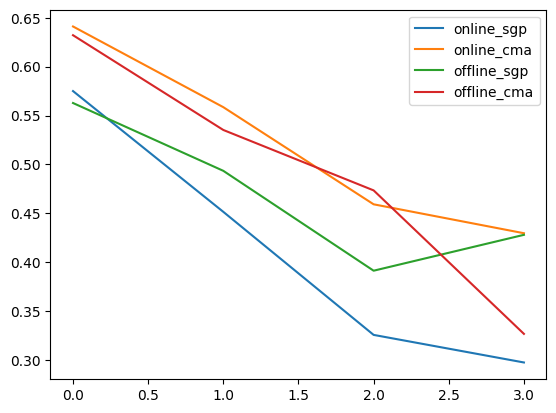

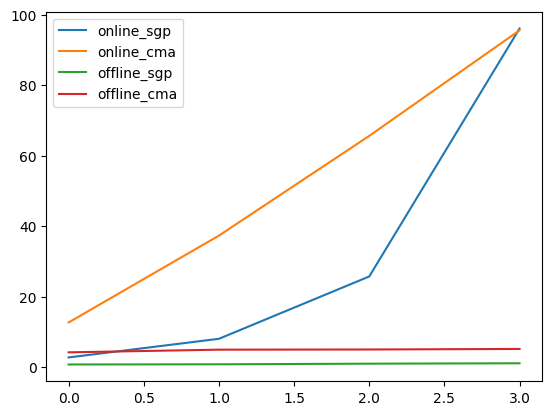

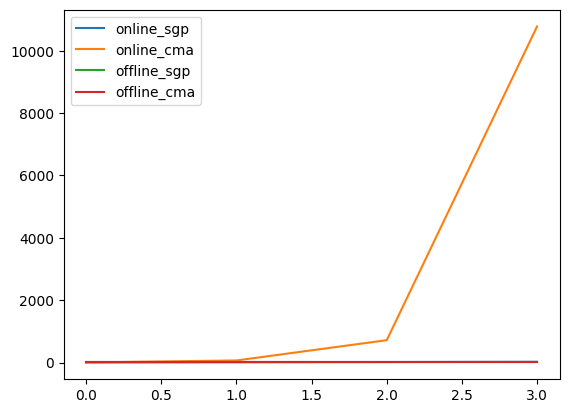

In [34]:
filename = f'../datasets/results/AIPP_4R_bathymetry_5S.json'
save_filename = filename[:-5] + '-{}.pdf'
results = json.load(open(filename, 'r'))

rmse = defaultdict(list)
param_time = defaultdict(list)
ipp_time = defaultdict(list)
for num_sensors in results.keys():
    for metric in results[num_sensors].keys():
        for method in  results[num_sensors][metric].keys():
            if metric=='RMSE':
                rmse[method].append(np.mean(results[num_sensors][metric][method]))
            if metric=='ParamTime':
                param_time[method].append(np.mean(results[num_sensors][metric][method]))
            if metric=='IPPTime':
                ipp_time[method].append(np.mean(results[num_sensors][metric][method]))

plt.figure()
for key in rmse.keys():
    plt.plot(rmse[key], label=key)
plt.legend()
plt.show()

plt.figure()
for key in ipp_time.keys():
    plt.plot(ipp_time[key], label=key)
plt.legend()
plt.show()

plt.figure()
for key in param_time.keys():
    plt.plot(param_time[key], label=key)
plt.legend()
plt.show()